# Udacity Self-Driving Car Engineer Nanodegree Program
## Vehicle Detection Project
---
The goals / steps of this project are the following:

- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
- Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
- Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
- Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
- Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
- Estimate a bounding box for vehicles detected.

### Import Statements

In [1]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML, display
import numpy as np
import pickle
import cv2
import glob
import time
import math
import tabulate

%matplotlib inline

print('---')

---


### Helper Functions

In [2]:
def display_and_save(images, titles=False, filename=False, gray=False):
    number_of_images = len(images)
    rows = math.ceil(number_of_images / 2)
    fig, axs = plt.subplots(rows, 2, figsize=(7, 3 * rows))
    fig.subplots_adjust(hspace=.2, wspace=.2)
    axs = axs.ravel()

    for i in range(2 * rows):
        axs[i].axis('off')

    for index, image in enumerate(images):
        if gray == True:
            axs[index].imshow(image, cmap='gray')
        else:
            axs[index].imshow(image)
        if titles:
            axs[index].set_title(titles[index], fontsize=15)

    if filename:
        fig.savefig('./assets/report/' + filename)
        
print("---")

---


### Load Training Data Set

In [3]:
car_images = glob.glob('./training_data/vehicles/**/*.png')
total_car_images = len(car_images)
non_car_images = glob.glob('./training_data/non-vehicles/**/*.png')
total_non_car_images = len(non_car_images)

print("There are {} car images".format(total_car_images))
print("There are {} non-car images".format(total_non_car_images))
print("---")

There are 3425 car images
There are 3900 non-car images
---


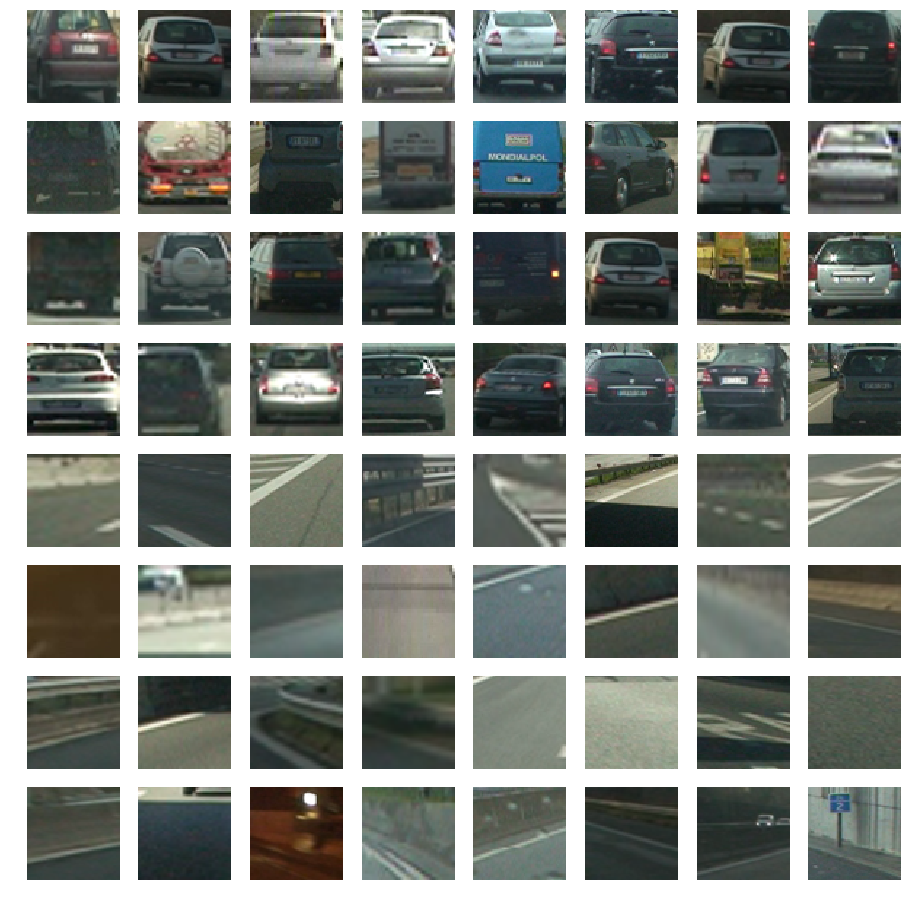

In [4]:
figure, axis = plt.subplots(8, 8, figsize=(16, 16))
figure.subplots_adjust(hspace=0.2, wspace=0.001)
axis = axis.ravel()

# Iterate through the car images
for index in range(32):
    image_index = np.random.randint(0, total_car_images)
    image = cv2.imread(car_images[image_index])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axis[index].axis('off')
    axis[index].imshow(image)

# Iterate through non-car images
for index in range(32, 64):
    image_index = np.random.randint(0, total_car_images)
    image = cv2.imread(non_car_images[image_index])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axis[index].axis('off')
    axis[index].imshow(image)
    
# save image
figure.savefig('./assets/report/cars.jpg')
    

### Convert to HOG (Histogram of Oriented Gradients)


Visulize HOG Images


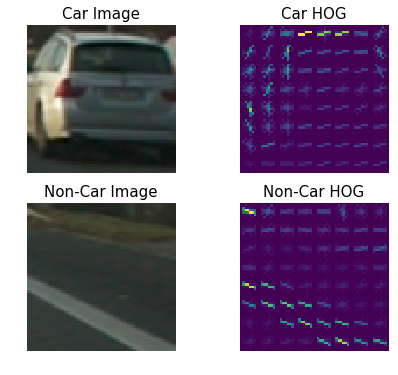

In [5]:
# if visulise = True, returns features, hog_image
# else returns features only
def convert_to_hog(image, orientations, pixel_per_cell, cell_per_block, visualise=False, feature_vector=True):
    return hog(image, orientations=orientations,
               pixels_per_cell=(pixel_per_cell, pixel_per_cell),
               cells_per_block=(cell_per_block, cell_per_block),
               transform_sqrt=False, visualise=visualise,
               feature_vector=feature_vector)

print("Visulize HOG Images")

output_images = []
output_titles = []
car_image = mpimg.imread(car_images[50])
_, car_destination = convert_to_hog(car_image[:, :, 2], 9, 8, 8, visualise=True, feature_vector=True)
non_car_image = mpimg.imread(non_car_images[50])
_, non_car_destination = convert_to_hog(non_car_image[:, :, 2], 9, 8, 8, visualise=True, feature_vector=True)

# Visualization
output_images.append(car_image)
output_titles.append("Car Image")
output_images.append(car_destination)
output_titles.append("Car HOG")
output_images.append(non_car_image)
output_titles.append("Non-Car Image")
output_images.append(non_car_destination)
output_titles.append("Non-Car HOG")
display_and_save(output_images, output_titles, filename="hog.jpg")

In [6]:

# Define a function to extract features from a list of image locations
# This function could also be used to call bin_spatial() and color_hist() (as in the lessons) to extract
# flattened spatial color features and color histogram features and combine them all (making use of StandardScaler)
# to be used together for classification
def extract_features(imgs, cspace='RGB', orientations=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call convert_to_hog() with visualise=False, feature_vector=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(convert_to_hog(feature_image[:,:,channel], orientations, pix_per_cell, cell_per_block, visualise=False, feature_vector=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = convert_to_hog(feature_image[:,:,hog_channel], orientations, pix_per_cell, cell_per_block, visualise=False, feature_vector=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

print('---')

---


### Explore HOG parameters
- This cell takes up to 25 min to run
- Should be commented out if not exploring with HOG parameters

In [7]:
# table = [];
# configuration = ["Run #", "Colorspace", "Orientations", "Pixels Per Cell", "Cells Per Block", "HOG Channel", "Extraction Time", "Classifier Type", "Accuracy", "Training Time"]
# table.append(configuration)
# # Constants
# orientations = 11
# pix_per_cell = 16
# cell_per_block = 2
# run_number = 1
# # Variable Factors
# for colorspace in ['RGB', 'HSV', 'LUV','HLS', 'YUV', 'YCrCb']:
#     for hog_channel in [0, 1, 2, "ALL"]:
#         # feature extraction
#         t1 = time.time()
#         car_features = extract_features(car_images, cspace=colorspace, orientations=orientations, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
#         non_car_features = extract_features(non_car_images, cspace=colorspace, orientations=orientations, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
#         t2 = time.time()
#         # Training
#         X = np.vstack((car_features, non_car_features)).astype(np.float64)  
#         y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))

#         # Split up data into randomized training and test sets
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=np.random.randint(0, 999))

#         # Use a SVM Classifier (Support Vector Machine)
#         svc = LinearSVC()
#         t1 = time.time()
#         svc.fit(X_train, y_train)
#         t2 = time.time()
#         duration = round(t2 - t1, 1)
#         accuracy = round(svc.score(X_test, y_test) * 100, 1)
        
#         # record data
#         configuration = [run_number, colorspace, orientations, pix_per_cell, cell_per_block, hog_channel, round(t2-t1, 1), "Linear SVC", accuracy, duration]
#         table.append(configuration)
#         run_number += 1
        
# display(HTML(tabulate.tabulate(table, tablefmt='html')))

### Extract HOG parameters

In [8]:
# Constants
orientations = 11
pix_per_cell = 16
cell_per_block = 2
colorspace = "YUV" # OR RGB, HSV, LUV, HLS, YUV, YCrCb
hog_channel = 'ALL' # OR 0, 1, 2, or "ALL"
# Variable Factors
t1 = time.time()
car_features = extract_features(car_images, cspace=colorspace, orientations=orientations, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
non_car_features = extract_features(non_car_images, cspace=colorspace, orientations=orientations, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
t2 = time.time()

print('It takes {} seconds to run'.format(round(t2 - t1), 2))

It takes 26 seconds to run


### Classifier Training

In [9]:
# Define the labels vector
X = np.vstack((car_features, non_car_features)).astype(np.float64)  
y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))

# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=np.random.randint(0, 999))

# Use a SVM Classifier (Support Vector Machine)
svc = LinearSVC()
t1 = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
# Metrics
training_time = (round(t2 - t1, 1))
accuracy = round(svc.score(X_test, y_test) * 100, 1)
print("Classifier takes", training_time, "seconds to achieve {}% accuracy.".format(accuracy))
print('Input data has shape {}'.format(X_train[0].shape))

Classifier takes 0.5 seconds to achieve 97.1% accuracy.
Input data has shape (1188,)


### Car Finding (Pre-pipeline)

In [10]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    
    # array of rectangles where cars were detected
    rectangles = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = convert_to_hog(ch1, orient, pix_per_cell, cell_per_block, feature_vector=False)   
    if hog_channel == 'ALL':
        hog2 = convert_to_hog(ch2, orient, pix_per_cell, cell_per_block, feature_vector=False)
        hog3 = convert_to_hog(ch3, orient, pix_per_cell, cell_per_block, feature_vector=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            ################ ONLY FOR BIN_SPATIAL AND COLOR_HIST ################

            # Extract the image patch
            #subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            #spatial_features = bin_spatial(subimg, size=spatial_size)
            #hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            #test_prediction = svc.predict(test_features)
            
            ######################################################################
            
            hog_features = np.array([hog_features])
            
            test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles
    
print('---')

---


### Draw Box 

In [11]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

print('---')

---


### Find & Draw Box Sample

10 rectangles found in image
-


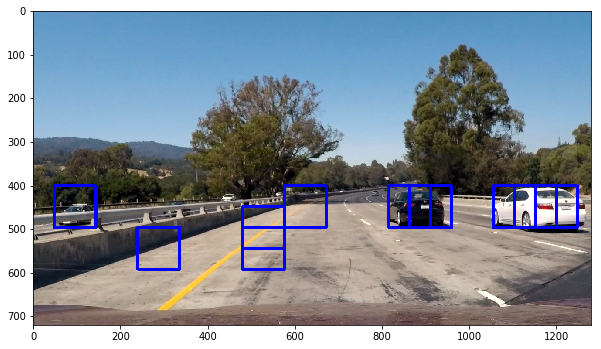

In [12]:
test_image = mpimg.imread('./assets/inputs/test1.jpg')
# Parameters
ystart = 400
ystop = 656
scale = 1.5
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
rectangles = find_cars(test_image, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None)
# Output
print(len(rectangles), 'rectangles found in image')
# Draw Box
output_image = draw_boxes(test_image, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(output_image)
plt.savefig("./assets/report/test1_output.jpg")
print('-')

### Multi-scale Windows

Number of boxes:  78


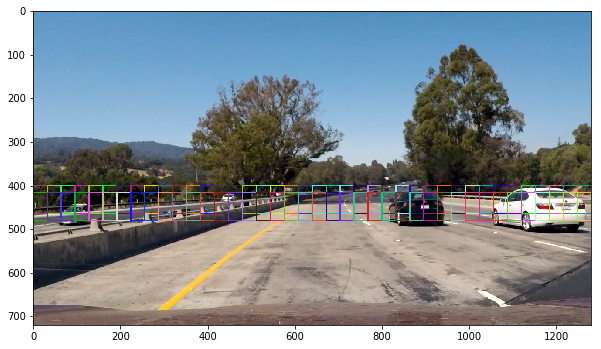

In [13]:
test_image = mpimg.imread('./assets/inputs/test1.jpg')

rects = []

ystart = 400
ystop = 464
scale = 1.0
rects.append(find_cars(test_image, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))
ystart = 416
ystop = 480
scale = 1.0
rects.append(find_cars(test_image, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))

rectangles = [item for sublist in rects for item in sublist] 
test_image_rects = draw_boxes(test_image, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_image_rects)
plt.savefig("./assets/report/window_1.jpg")
print('Number of boxes: ', len(rectangles))


Number of boxes:  50


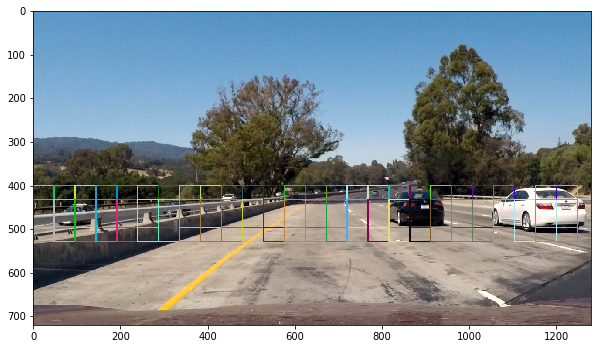

In [14]:

test_image = mpimg.imread('./assets/inputs/test1.jpg')

rects = []

ystart = 400
ystop = 496
scale = 1.5
rects.append(find_cars(test_image, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))
ystart = 432
ystop = 528
scale = 1.5
rects.append(find_cars(test_image, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))

rectangles = [item for sublist in rects for item in sublist] 
test_image_rects = draw_boxes(test_image, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_image_rects)
plt.savefig("./assets/report/window_2.jpg")
print('Number of boxes: ', len(rectangles))

Number of boxes:  38


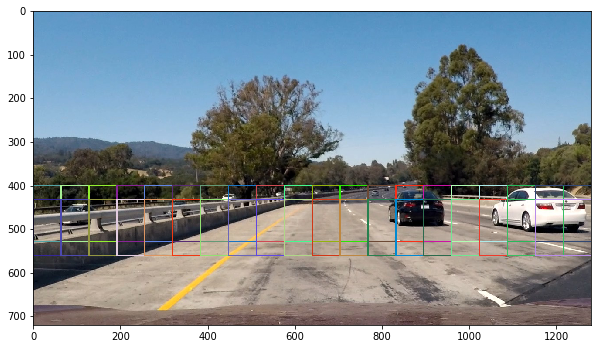

In [15]:
test_image = mpimg.imread('./assets/inputs/test1.jpg')

rects = []

ystart = 400
ystop = 528
scale = 2.0
rects.append(find_cars(test_image, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))
ystart = 432
ystop = 560
scale = 2.0
rects.append(find_cars(test_image, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))

rectangles = [item for sublist in rects for item in sublist] 
test_image_rects = draw_boxes(test_image, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_image_rects)
plt.savefig("./assets/report/window_3.jpg")
print('Number of boxes: ', len(rectangles))

Number of boxes:  24


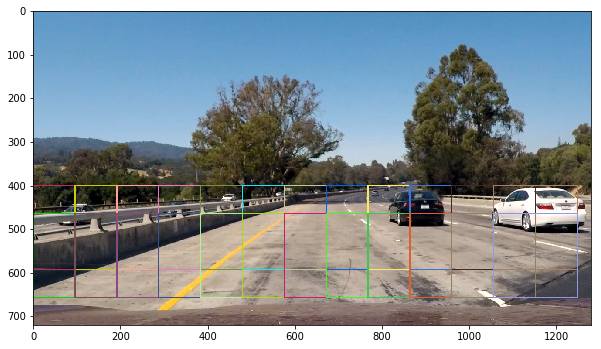

In [16]:
test_image = mpimg.imread('./assets/inputs/test1.jpg')

rects = []

ystart = 400
ystop = 596
scale = 3.0
rects.append(find_cars(test_image, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))
ystart = 464
ystop = 660
scale = 3.0
rects.append(find_cars(test_image, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))

rectangles = [item for sublist in rects for item in sublist] 
test_image_rects = draw_boxes(test_image, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_image_rects)
plt.savefig("./assets/report/window_4.jpg")
print('Number of boxes: ', len(rectangles))

### Combine Window Search

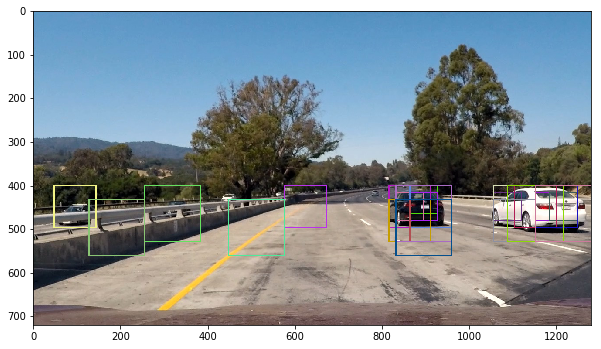

In [17]:
test_image = mpimg.imread('./assets/inputs/test1.jpg')

rectangles = []

colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

y_starts = [400, 416, 400, 432, 400, 432, 400, 464]
y_stops = [464, 480, 496, 528, 528, 560, 596, 660]
scales = [1.0, 1.0, 1.5, 1.5, 2.0, 2.0, 3.5, 3.5]

for y_start, y_stop, scale in zip(y_starts, y_stops, scales):
    rectangles.append(find_cars(test_image, y_start, y_stop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None))

# apparently this is the best way to flatten a list of lists
rectangles = [item for sublist in rectangles for item in sublist] 
test_image_rects = draw_boxes(test_image, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_image_rects)
plt.savefig("./assets/report/window_mutiple.jpg")

### Heatmap

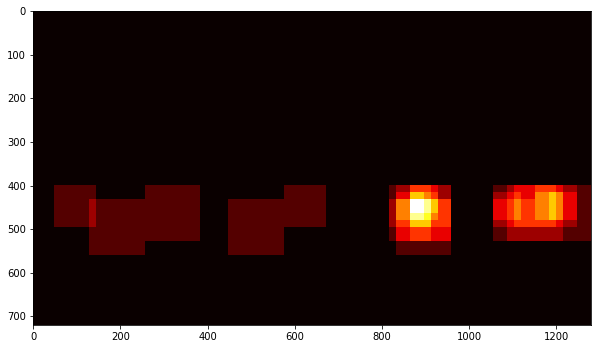

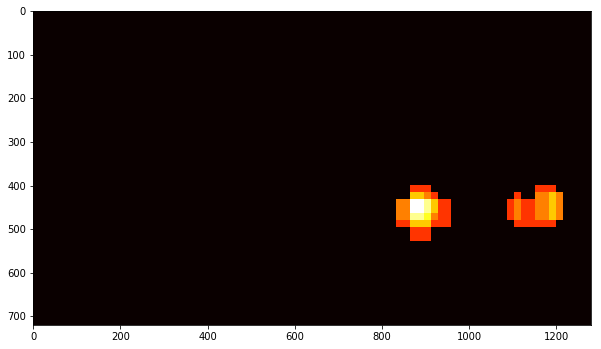

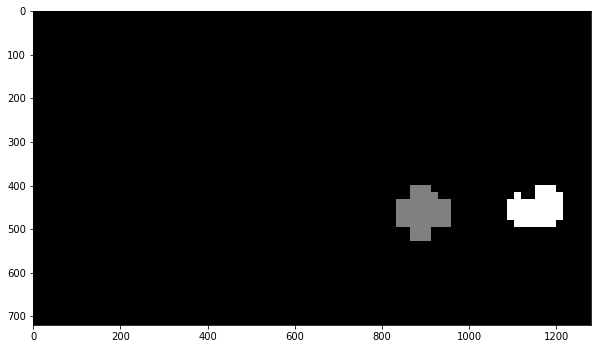

In [18]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

test_image = mpimg.imread('./assets/inputs/test1.jpg')
heatmap_image = np.zeros_like(test_image[:,:,0])
heatmap_image = add_heat(heatmap_image, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_image, cmap='hot')
plt.savefig("./assets/report/heatmap.jpg")

heatmap_image = apply_threshold(heatmap_image, 3)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_image, cmap='hot')
plt.savefig("./assets/report/heatmap_threshold.jpg")

# Apply SciPy Labels to Heatmap
labels = label(heatmap_image)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
plt.savefig("./assets/report/heatmap_scipy.jpg")

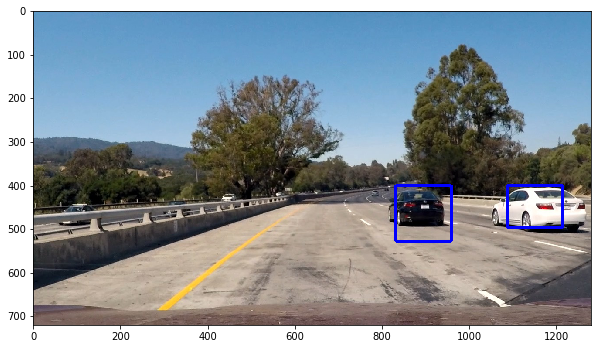

In [19]:
test_image = mpimg.imread('./assets/inputs/test1.jpg')
heatmap_image = np.zeros_like(test_image[:,:,0])
heatmap_image = add_heat(heatmap_image, rectangles)

def draw_labeled_bboxes(image, labels):
    # Iterate through all detected cars
    rectangles = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rectangles.append(bbox)
        # Draw the box on the image
        cv2.rectangle(image, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangleangles
    return image, rectangles

# Draw bounding boxes on a copy of the image
draw_image, rectangle = draw_labeled_bboxes(np.copy(test_image), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_image)
plt.savefig("./assets/report/output_sample.jpg")

### Pipeline

In [20]:
def pipeline(image):
    rectangles = []
    # Configuration
    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    # Windows
    y_starts = [400, 416, 400, 432, 400, 432, 400, 464]
    y_stops = [464, 480, 496, 528, 528, 560, 596, 660]
    scales = [1.0, 1.0, 1.5, 1.5, 2.0, 2.0, 3.5, 3.5]


    for y_start, y_stop, scale in zip(y_starts, y_stops, scales):
        rectangles.append(find_cars(image, y_start, y_stop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None))

    rectangles = [item for sublist in rectangles for item in sublist] 
    
    heatmap_image = np.zeros_like(image[:,:,0])
    heatmap_image = add_heat(heatmap_image, rectangles)
    heatmap_image = apply_threshold(heatmap_image, 3)
    labels = label(heatmap_image)
    draw_image, rects = draw_labeled_bboxes(np.copy(image), labels)
    return draw_image

print('---')

---


### Process Images

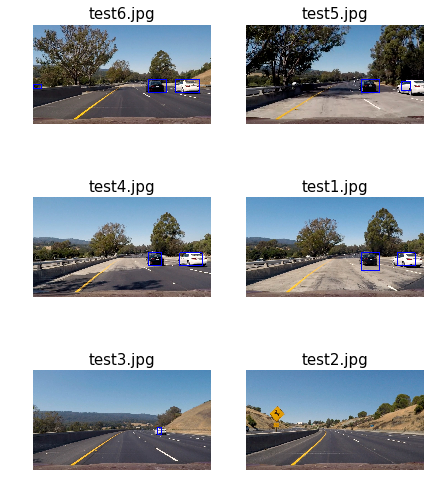

In [21]:
input_images = glob.glob('./assets/inputs/*.jpg')
output_images = []
output_titles = []

for index, image_path in enumerate(input_images):
    clean_path = image_path.split('/')[-1]
    image = mpimg.imread(image_path)
    output_image = pipeline(image)
    output_images.append(output_image)
    output_titles.append(clean_path)
    mpimg.imsave('./outputs/' + clean_path, output_image)
    
display_and_save(output_images, output_titles, filename="output_images.jpg")

In [22]:
video_paths = glob.glob('./assets/inputs/*.mp4')


for video_path in video_paths:
    clean_name = video_path.split('/')[-1]
    print(clean_name)
    project_video = VideoFileClip(video_path)
    output_video = project_video.fl_image(pipeline)
    %time output_video.write_videofile("./outputs/" + clean_name, audio=False)

project_video.mp4
[MoviePy] >>>> Building video ./outputs/project_video.mp4
[MoviePy] Writing video ./outputs/project_video.mp4


100%|█████████▉| 1260/1261 [05:56<00:00,  4.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./outputs/project_video.mp4 

CPU times: user 4min 21s, sys: 32.6 s, total: 4min 53s
Wall time: 5min 57s
test_video.mp4
[MoviePy] >>>> Building video ./outputs/test_video.mp4
[MoviePy] Writing video ./outputs/test_video.mp4


 97%|█████████▋| 38/39 [00:08<00:00,  4.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./outputs/test_video.mp4 

CPU times: user 6.92 s, sys: 843 ms, total: 7.76 s
Wall time: 9.86 s
